In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

# 定义中文显示字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

## 创建老虎机的类

### 属性:

@k_arm:k条手臂

@epsilon: $\varepsilon$-贪心算法探索概率

@initial: 每个动作的初始估计

@step_size: 用于更新估计的恒定步长

@sample_averages:如果为真，则使用样本平均来更新估计值，而不是固定的步长

@UCB_param: 如果不是None，使用UCB算法选择动作

@gradient:如果为真，则使用基于梯度的bandit算法

@gradient_baseline:如果为真，使用平均奖励作为基于梯度的bandit算法的基线


### 算法
#### UCB算法：
基于置信度上界的动作选择

$$
A_{t\,\,}=\underset{a}{arg\max}\left[ Q_t\left( a \right) +c\sqrt{\frac{\ln t}{N_t\left( a \right)}} \right] 
$$

#### 梯度赌博机算法：
$$
Pr\left\{ A_t=a \right\} \doteq \small{\frac{e^{H_t\left( a \right)}}{\sum\nolimits_{b=1}^k{e^{H_t\left( b \right)}}}}=\pi _t\left( a \right) 
$$


   

In [2]:
class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)#索引0-9
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    #重新调整
    def reset(self):
        # 每个动作的真正奖励
        self.q_true = np.random.randn(self.k) + self.true_reward
        #np.random.randn(self.k)生成一个服从标准正态分布（均值为0，标准差为1）的随机数数组。

        # 每个动作的估计奖励
        self.q_estimation = np.zeros(self.k) + self.initial

        # 每个动作选择的时间
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)#np.argmax是 NumPy 库中的一个函数，用于返回数组中指定轴上最大值的索引

        self.time = 0

    # 对这个老虎机采取行动
    def act(self):
        #epsilon贪心策略
        if np.random.rand() < self.epsilon:#np.random.rand() 是 NumPy 库中用于生成指定形状的随机数数组的函数，其中生成的随机数服从均匀分布在 [0, 1) 区间内。
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))#self.UCB_param为c的值
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])
        '''np.where(UCB_estimation == q_best) 这一部分是一个条件语句，它会返回一个布尔数组，表示 UCB_estimation 数组中哪些元素等于 q_best。
            np.where(UCB_estimation == q_best)[0] 选择满足条件的元素的索引，然后 [0] 是为了提取出这些索引，因为 np.where() 返回的是一个元组，第一个元素是满足条件的索引数组。
            最后,np.random.choice() 会从这些满足条件的索引中随机选择一个索引，并返回该索引对应的值。
            所以，整个代码的作用是从 UCB_estimation 数组中随机选择一个值等于 q_best 的元素的索引，并返回该索引。'''

        if self.gradient:#使用基于梯度的bandit算法
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)
        '''p=self.action_prob 是一个可选参数，它表示每个索引被选择的概率分布。这意味着 np.random.choice() 会根据 self.action_prob 中定义的概率分布来选择索引值。'''

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # 采取一个行动，更新该行动的估计
    def step(self, action):
        #在N下生成奖励(真实奖励，1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time#更新平均收益

        if self.sample_averages:
            # 使用样本平均值更新估计
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:#使用基于梯度的bandit算法
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:#使用平均奖励作为基于梯度的bandit算法的基线
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)#self.step_size固定步长
        else:
            # 用恒定的步长更新估计
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

跑个仿真

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)#rewards.shape 返回的是一个数组（或者类似数组的数据结构）的形状，通常是一个元组，其中包含数组的维度大小。
    for i, bandit in enumerate(bandits):
        '''这段代码使用 enumerate() 函数遍历一个类似于列表的对象 bandits 中的每个元素，并在每次迭代中获取元素及其索引。
            enumerate() 函数会返回一个迭代器，其中每个元素都是一个元组，包含元素的索引和值。
            在循环开始时，i 是当前元素的索引，bandit 是对应的元素。
            在循环体中，你可以使用 i 和 bandit 来访问当前元素的索引和值，并对其进行操作。'''
        for r in trange(runs):#训练runs轮
            bandit.reset()
            for t in range(time):#每轮仿真时间
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)#这行代码看起来是在计算 best_action_counts 中每行的平均值，因为它使用了 mean(axis=1)。axis=1 意味着沿着第二个轴（即行）进行计算。
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

图1

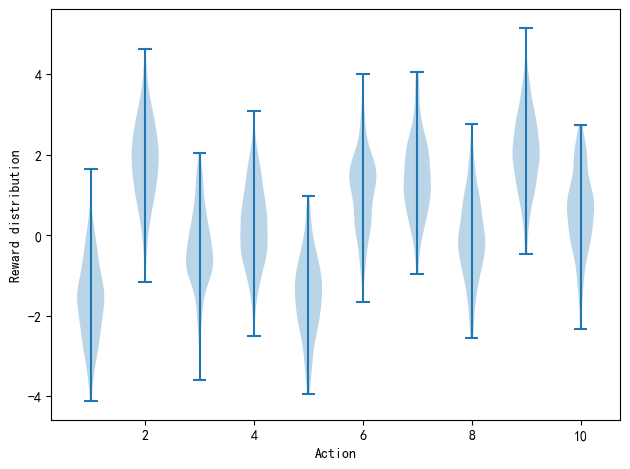

In [16]:
plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.tight_layout()
plt.show()

图2

100%|██████████| 10000/10000 [15:27<00:00, 10.78it/s]


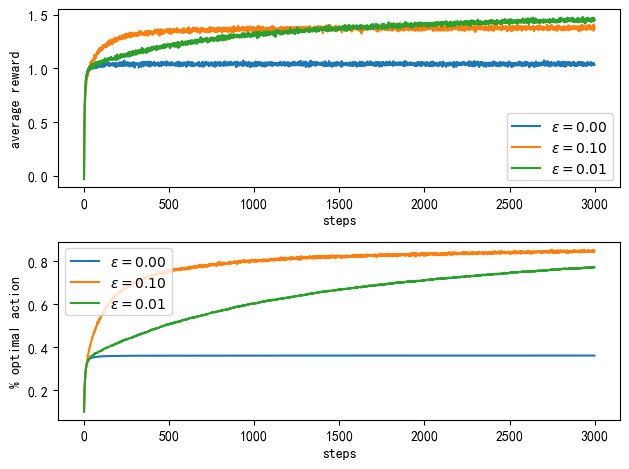

In [5]:
epsilons = [0, 0.1, 0.01]
bandits2 = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = simulate(runs=10000, time=3000,bandits=bandits2)

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()
plt.tight_layout()
plt.show()

图3

100%|██████████| 10000/10000 [05:03<00:00, 32.91it/s]


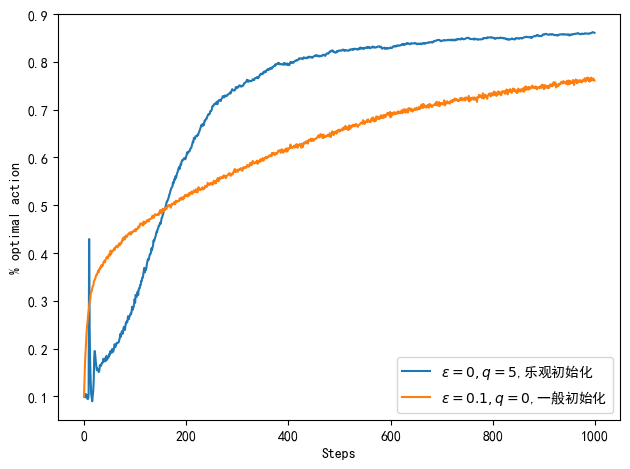

In [6]:
bandits3 = []
bandits3.append(Bandit(epsilon=0, initial=5, step_size=0.1))
bandits3.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = simulate(runs=10000, time=1000, bandits = bandits3)

plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$,乐观初始化')
plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$,一般初始化')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()
plt.tight_layout()
plt.show()

图4

100%|██████████| 10000/10000 [05:41<00:00, 29.27it/s]


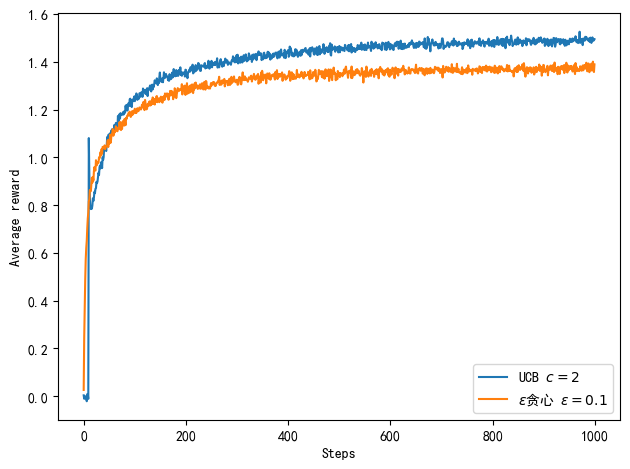

In [7]:
bandits4 = []
bandits4.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits4.append(Bandit(epsilon=0.1, sample_averages=True))
_, average_rewards = simulate(runs=10000, time=1000, bandits = bandits4)

plt.plot(average_rewards[0], label='UCB $c = 2$')
plt.plot(average_rewards[1], label='$\epsilon$贪心 $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.tight_layout()
plt.show()

图5

100%|██████████| 10000/10000 [10:15<00:00, 16.23it/s]


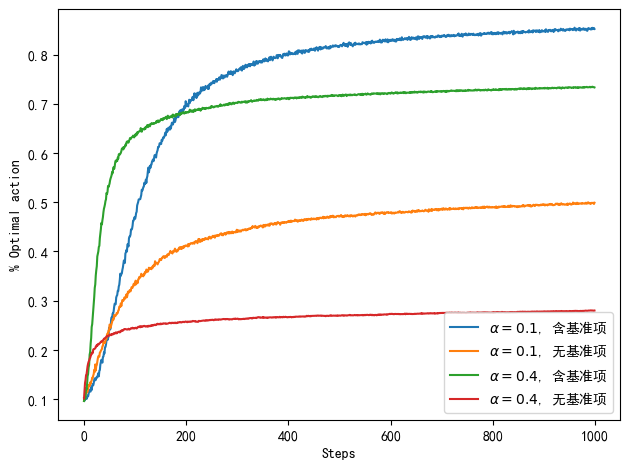

In [8]:
bandits5 = []
bandits5.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits5.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits5.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits5.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs=10000, time=1000, bandits = bandits5)
labels = [r'$\alpha = 0.1$, 含基准项',
          r'$\alpha = 0.1$, 无基准项',
          r'$\alpha = 0.4$, 含基准项',
          r'$\alpha = 0.4$, 无基准项']

for i in range(len(bandits5)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.tight_layout()
plt.show()

图6

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [05:39<00:00, 29.45it/s]


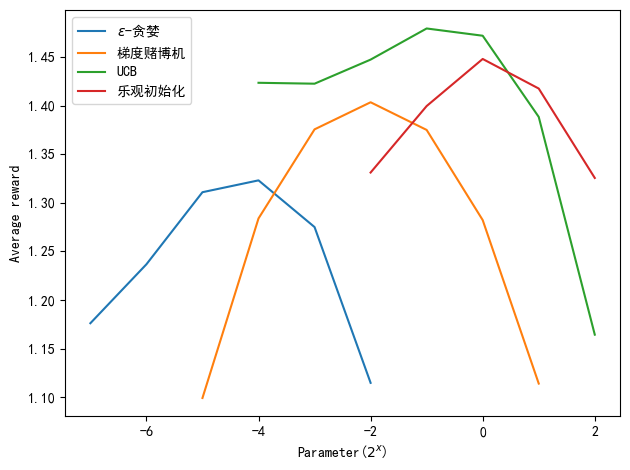

In [9]:
labels = ['$\epsilon$-贪婪', '梯度赌博机',
              'UCB', '乐观初始化']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float64),
                  np.arange(-5, 2, dtype=np.float64),
                  np.arange(-4, 3, dtype=np.float64),
                  np.arange(-2, 3, dtype=np.float64)]

bandits6 = []
for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits6.append(generator(pow(2, param)))

_, average_rewards = simulate(runs=10000, time=1000, bandits = bandits6)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()
plt.tight_layout()
plt.show()